1. Simulate the true event time vectors for both target and source, denoted as $\mathbf{Y}_s\mathbf{Y}_t$: 

*The source model is*

$$y_s = \left(\frac{-\log U}{\lambda\exp\mathbf{x}_s^T\boldsymbol{\omega}_s}\right)^{1/\nu},U\sim \mathcal{U}(0,1)$$

where $\lambda$ and $\nu$ are parameters of Weibull distributions.

*The target model is:*

$$y_t = \left(\frac{-\log U}{\lambda\exp\mathbf{x}_t^T\boldsymbol{\omega}_t}\right)^{1/\nu}.$$

Generate 1000 $y_s$ and 100 $y_t$  using $\boldsymbol{\beta},\boldsymbol{\omega}\in R^{5}$ and $\mathbf{x}_t,\mathbf{x}_s\in R^{5}$. Note that for each pair $(\omega_j,\beta_j),j=1,\cdots,5$, we have

$$(\omega_j,\beta_j)\sim^{i.i.d}\mathcal{N}\left(1,\left(\begin{matrix}\alpha_s^{2}&\rho\alpha_s\alpha_t\\\rho\alpha_s\alpha_t&\alpha_t^{2}\end{matrix}\right)\right)$$. 

*We consider right censoring,*

- Assume ~35% of source populations are censored and ~35% of target population are censored, the censoring time is
$$C_s,C_t\sim_{iid}Weibull(\lambda_c,\nu_c).$$

- We observe $(Y_{s},\delta_{s})\ (Y_{t},\delta_{t})$, where $\delta_i,\ i\in\{s,t\}$ is the binary censoring indicator, with 1 denoting event and 0 denoting censoring.
<font color="red">Among the five covariates, three of them are continuous, $Z_1\sim\mathcal{N}(1.05,0.0225), Z_2\sim\mathcal{N}(30,25), Z_3\sim\mathcal{N}(90,25)$. Two of them are discrete $Z_4,Z_5 \sim Ber(0.5).$</font>

- Creatinine is a waste product produced by the muscles and is filtered from the blood by the kidneys. It's commonly used as a marker for kidney function, and its levels in the bloodstream can indicate how well the kidneys are working.The normal range for creatinine in the blood varies by age, sex, and muscle mass. Here are the general reference ranges for serum creatinine in adults:
    * Men: 0.74 to 1.35 mg/dL

- The Urine Albumin-to-Creatinine Ratio (UACR) measures the amount of albumin in the urine compared to creatinine. It's a commonly used test to detect early kidney damage, especially in people with diabetes or hypertension.The normal range for UACR is: 
    * Less than 30 mg/g:
    * Normal 30-299 mg/g: Moderately increased (sometimes termed "microalbuminuria") 
    * 300 mg/g and above: Severely increased (sometimes termed "macroalbuminuria")

- The estimated glomerular filtration rate (eGFR) is a test used to assess how well the kidneys are functioning. It is estimated based on a formula that includes serum creatinine levels, age, gender, and sometimes other factors.The normal eGFR range varies by age, as kidney function can decrease naturally with age. In adults, the general breakdown for eGFR values is:

    * eGFR >90 mL/min/1.73 m²: Normal or high function
    * eGFR 60-89 mL/min/1.73 m²: Slightly decreased function; may be considered normal for some patients, especially the elderly.
    * eGFR 45-59 mL/min/1.73 m²: Mildly decreased function (stage 3a chronic kidney disease, CKD)
    * eGFR 30-44 mL/min/1.73 m²: Moderately decreased function (stage 3b CKD)
    * eGFR 15-29 mL/min/1.73 m²: Severely decreased function (stage 4 CKD)
    * eGFR <15 mL/min/1.73 m²: Kidney failure (stage 5 CKD or end-stage renal disease)

2. Split the target data into testing and training part in a ratio of 1:1, named as $Z_{target\ training}$
 and $Z_{target\ testing}$
3. Apply the methods  (we use CoxKL in this setting) to obtain $\widehat{\boldsymbol{\omega}}$ to estimate $\widehat{\beta}$, and then obtain $Z_{target\ testing}\widehat{\beta}$.
4. Compute C-index and other measures of performances.
5. Repeat step 3 and 4 using different values of $\eta$.


# Simulation Codes

In [24]:
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal, weibull_min, bernoulli
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

np.random.seed(123)

def generate_survival_data(N_s=1000, N_t=100, alpha_s=.5, alpha_t=.5, rho=0.6, 
                           lambda_val=5, nu=5, lambda_c= 1.25,nu_c = 1, dim=15, random_state = 'RS_42'):
    rs = int(random_state.split("_")[1])
    # Set random seed
    np.random.seed(rs)
    sample_size_name = "S{}_T{}".format(N_s,N_t)
    quality_name = "rho{}".format(rho)
    cov_matrix = [[alpha_s**2, rho*alpha_s*alpha_t], [rho*alpha_s*alpha_t, alpha_t**2]]

    omega_beta = multivariate_normal.rvs([1, 1], cov_matrix, size=dim)
    
    sign = (2 * bernoulli.rvs(0.5, size=dim) - 1)
    omega_s, omega_t = sign * omega_beta[:, 0], sign * omega_beta[:, 1]
   
    Z1 = np.random.normal(1.05, 0.0225, (N_s + N_t, 1))
    Z2 = np.random.normal(30, 5, (N_s + N_t, 1))
    Z3 = np.random.normal(90, 5, (N_s + N_t, 1))
    Z4 = np.random.normal(15, 2, (N_s + N_t, 1))
    Z5 = np.random.normal(25, 3, (N_s + N_t, 1))
    Z6 = np.random.normal(35, 1, (N_s + N_t, 1))
    Z7 = np.random.normal(14, 2, (N_s + N_t, 1))
    Z8 = np.random.normal(10, 3, (N_s + N_t, 1))
    Z9 = np.random.normal(15, 4, (N_s + N_t, 1))
    Z10 = np.random.normal(20, 5, (N_s + N_t, 1))
    Z11 = bernoulli.rvs(0.5, size=(N_s + N_t, 1))
    Z12 = bernoulli.rvs(0.5, size=(N_s + N_t, 1))
    Z13 = bernoulli.rvs(0.5, size=(N_s + N_t, 1))
    Z14 = bernoulli.rvs(0.3, size=(N_s + N_t, 1)) 
    Z15 = bernoulli.rvs(0.7, size=(N_s + N_t, 1))

    scaler = StandardScaler()
    Z_continuous = np.hstack([Z1,Z2,Z3,Z4 ,Z5,Z6 ,Z7 ,Z8 ,Z9, Z10])
    Z_continuous = scaler.fit_transform(Z_continuous)

    X = np.hstack([Z_continuous,Z11,Z12,Z13,Z14,Z15])
    X_s, X_t = X[:N_s], X[N_s:]

    U = np.random.uniform(0, 1, N_s)
    y_s = ((-np.log(U) / (lambda_val * np.exp(X_s.dot(omega_s))))**(1/nu))

    U = np.random.uniform(0, 1, N_t)
    y_t = ((-np.log(U) / (lambda_val * np.exp(X_t.dot(omega_t))))**(1/nu))

    C_s = weibull_min.rvs(c=nu_c, scale=lambda_c, size=N_s)
    C_t = weibull_min.rvs(c=nu_c, scale=lambda_c, size=N_t)

    y_s_obs = np.minimum(y_s, C_s)
    y_t_obs = np.minimum(y_t, C_t)

    delta_s = (y_s <= C_s).astype(int)
    delta_t = (y_t <= C_t).astype(int)
    print(np.mean(delta_s),np.mean(delta_t))
    
    
    formatted_number = format(0.5*( (1-np.mean(delta_s) + (1-np.mean(delta_t)))), '.2f')
    censoring_name = "CS{}".format(str(formatted_number))
    
    pd.DataFrame(omega_s).to_csv("../data/Simulated_Data/TrueS_{}_{}_{}_{}".format(quality_name,censoring_name,sample_size_name,random_state),index=False)
    pd.DataFrame(omega_t).to_csv("../data/Simulated_Data/TrueT_{}_{}_{}_{}".format(quality_name,censoring_name,sample_size_name,random_state),index=False)
    
    X_t_train, X_t_test, y_t_train_obs, y_t_test_obs, delta_t_train, delta_t_test = train_test_split(
        X_t, y_t_obs, delta_t, test_size=0.5, random_state=42
    )

    df_X_s = pd.DataFrame(X_s, columns=[f'X_{i}' for i in range(X_s.shape[1])])
    df_y_s_obs = pd.DataFrame(y_s_obs, columns=["y_s_obs"])
    df_delta_s = pd.DataFrame(delta_s, columns=["delta_s"])

    final_data_s = pd.concat([df_X_s, df_y_s_obs, df_delta_s], axis=1)
    #print(final_data_s.head(5))
    final_data_s.to_csv('../data/Simulated_Data/final_data_s_{}_{}_{}_{}.csv'.format(quality_name,censoring_name,sample_size_name,random_state), index=False)

    df_X_t_train = pd.DataFrame(X_t_train, columns=[f'X_{i}_train' for i in range(X_t_train.shape[1])])
    df_X_t_test = pd.DataFrame(X_t_test, columns=[f'X_{i}_test' for i in range(X_t_test.shape[1])])
    df_y_t_train_obs = pd.DataFrame(y_t_train_obs, columns=["y_t_train_obs"])
    df_y_t_test_obs = pd.DataFrame(y_t_test_obs, columns=["y_t_test_obs"])
    df_delta_t_train = pd.DataFrame(delta_t_train, columns=["delta_t_train"])
    df_delta_t_test = pd.DataFrame(delta_t_test, columns=["delta_t_test"])

    train_data = pd.concat([df_X_t_train, df_y_t_train_obs, df_delta_t_train], axis=1)
    test_data = pd.concat([df_X_t_test, df_y_t_test_obs, df_delta_t_test], axis=1)

    train_data['type'] = 'train'
    test_data['type'] = 'test'

    final_data_t = pd.DataFrame(np.vstack([train_data, test_data]))
    final_data_t.columns = [f'X_{i}_train' for i in range(1,16,1)] + ['y_t_obs','delta_t','type']
    final_data_t.to_csv('../data/Simulated_Data/final_data_t_{}_{}_{}_{}.csv'.format(quality_name,censoring_name,sample_size_name,random_state), index=False)
    
    return final_data_t, final_data_s, omega_s, omega_t, y_t

# Example call:
for i in range(1, 1000, 10):
    rs = "RS_" + str(i)
    t_csv, s_csv, omega_s, omega_t, y_t = generate_survival_data(N_s=5000, N_t=1000, rho=0.8, 
                                            alpha_s=.5, alpha_t=.5, lambda_val=5,
                                            nu=5, lambda_c=.45 ,nu_c=1., random_state=rs)

0.316 0.369
0.2204 0.199
0.35 0.348
0.2378 0.235
0.196 0.22
0.2012 0.207
0.2214 0.23
0.2632 0.219
0.2666 0.273
0.3202 0.389
0.32 0.314
0.339 0.281
0.1444 0.127
0.4532 0.456
0.3172 0.351
0.1922 0.162
0.265 0.261
0.3962 0.44
0.2166 0.23
0.2356 0.221
0.238 0.278
0.3664 0.36
0.2448 0.254
0.2444 0.281
0.2642 0.283
0.1542 0.152
0.252 0.209
0.294 0.286
0.1674 0.136
0.2154 0.216
0.2896 0.262
0.2548 0.281
0.2908 0.312
0.297 0.281
0.3628 0.398
0.215 0.231
0.128 0.13
0.2402 0.269
0.216 0.175
0.354 0.327
0.2696 0.286
0.2706 0.225
0.3976 0.415
0.2216 0.203
0.192 0.198
0.2856 0.304
0.251 0.228
0.3868 0.378
0.203 0.235
0.3112 0.286
0.294 0.276
0.2904 0.34
0.2726 0.258
0.259 0.238
0.1252 0.142
0.2304 0.2
0.337 0.335
0.3282 0.32
0.3276 0.331
0.3506 0.371
0.2924 0.29
0.2674 0.247
0.3552 0.363
0.2438 0.254
0.3118 0.302
0.3132 0.271
0.202 0.199
0.304 0.277
0.31 0.332
0.2862 0.301
0.2344 0.264
0.1598 0.18
0.1944 0.201
0.3208 0.315
0.3608 0.363
0.3182 0.316
0.3836 0.373
0.3304 0.286
0.3964 0.421
0.204 0.224

In [11]:
omega_s,omega_t

(array([-1.35726565, -1.10393762, -1.01333915, -2.21889208, -0.5365574 ,
         1.33699878,  0.39359106,  1.2792761 , -0.39212575, -0.46267399,
        -0.41452994, -1.25799008,  1.69560519, -0.79561648, -1.20269584]),
 array([-1.67265397, -0.62760541, -1.53556924, -2.08325799, -0.26247002,
         1.30704917,  0.19155251,  1.14192217,  0.29939673, -0.58479685,
        -0.8859408 , -1.62981988,  1.49393046, -0.34382797, -0.93018501]))

(array([475., 303., 122.,  48.,  26.,  13.,   7.,   2.,   2.,   2.]),
 array([0.06499223, 0.83738758, 1.60978294, 2.38217829, 3.15457365,
        3.926969  , 4.69936436, 5.47175971, 6.24415507, 7.01655043,
        7.78894578]),
 <BarContainer object of 10 artists>)

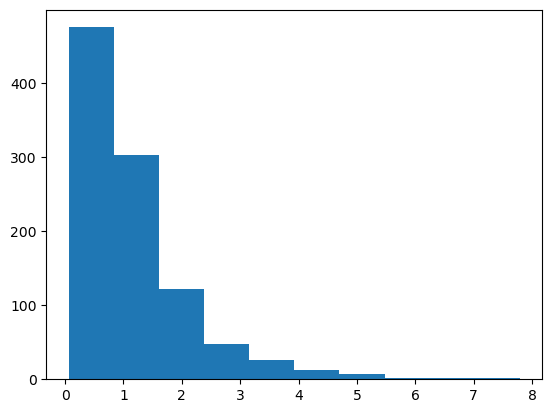

In [12]:
import matplotlib.pyplot as plt

plt.hist(y_t)

$\lambda_c= 1.8,\nu_c =  0.9$ corresponds to censoring rate around 0.338 and 0.32 for source and target respectively

In [19]:
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal, weibull_min, bernoulli
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

np.random.seed(123)
def test(N_s=1000, N_t=100, alpha_s=.5, alpha_t=.5, rho=0.99, 
                           lambda_val=10, nu=1,quality = 'Good_Quality',
                          lambda_c= 1.8,nu_c = 0.9,dim=15):
   
    if (lambda_c == 1.8) and (nu_c ==  0.9):
        censoring_name = "CR0.3"
        
    sample_size_name = "S{}_T{}".format(N_s,N_t)
    quality_name = "rho{}".format(rho)
    cov_matrix = [[alpha_s**2, rho*alpha_s*alpha_t], [rho*alpha_s*alpha_t, alpha_t**2]]

    omega_beta = multivariate_normal.rvs([1, 1], cov_matrix, size=dim)
    
    sign = (2 * bernoulli.rvs(0.5, size=dim) - 1)
    omega_s, omega_t = sign * omega_beta[:, 0], sign * omega_beta[:, 1]
    # pd.DataFrame(omega_s).to_csv("TrueS_{}_{}_{}".format(quality_name,censoring_name,sample_size_name),index=False)
    # pd.DataFrame(omega_t).to_csv("TrueT_{}_{}_{}".format(quality_name,censoring_name,sample_size_name),index=False)
    Z1 = np.random.normal(1.05, 0.0225, (N_s + N_t, 1))
    Z2 = np.random.normal(30, 5, (N_s + N_t, 1))
    Z3 = np.random.normal(90, 5, (N_s + N_t, 1))
    Z4 = np.random.normal(15, 2, (N_s + N_t, 1))
    Z5 = np.random.normal(25, 3, (N_s + N_t, 1))
    Z6 = np.random.normal(35, 1, (N_s + N_t, 1))
    Z7 = np.random.normal(14, 2, (N_s + N_t, 1))
    Z8 = np.random.normal(10, 3, (N_s + N_t, 1))
    Z9 = np.random.normal(15, 4, (N_s + N_t, 1))
    Z10 = np.random.normal(20, 5, (N_s + N_t, 1))
    Z11 = bernoulli.rvs(0.5, size=(N_s + N_t, 1))
    Z12 = bernoulli.rvs(0.5, size=(N_s + N_t, 1))
    Z13 = bernoulli.rvs(0.5, size=(N_s + N_t, 1))
    Z14 = bernoulli.rvs(0.3, size=(N_s + N_t, 1)) 
    Z15 = bernoulli.rvs(0.7, size=(N_s + N_t, 1))

    scaler = StandardScaler()
    Z_continuous = np.hstack([Z1,Z2,Z3,Z4 ,Z5,Z6 ,Z7 ,Z8 ,Z9, Z10])
    Z_continuous = scaler.fit_transform(Z_continuous)

    X = np.hstack([Z_continuous,Z11,Z12,Z13,Z14,Z15])
    X_s, X_t = X[:N_s], X[N_s:]

    U = np.random.uniform(0, 1, N_s)
    y_s = ((-np.log(U) / (lambda_val * np.exp(X_s.dot(omega_s))))**(1/nu))

    U = np.random.uniform(0, 1, N_t)
    y_t = ((-np.log(U) / (lambda_val * np.exp(X_t.dot(omega_t))))**(1/nu))

    C_s = weibull_min.rvs(c=nu_c, scale=lambda_c, size=N_s)
    C_t = weibull_min.rvs(c=nu_c, scale=lambda_c, size=N_t)

    y_s_obs = np.minimum(y_s, C_s)
    y_t_obs = np.minimum(y_t, C_t)

    delta_s = (y_s <= C_s).astype(int)
    delta_t = (y_t <= C_t).astype(int)
    print(np.mean(delta_s),np.mean(delta_t))

    X_t_train, X_t_test, y_t_train_obs, y_t_test_obs, delta_t_train, delta_t_test = train_test_split(
        X_t, y_t_obs, delta_t, test_size=0.5, random_state=42
    )

    df_X_s = pd.DataFrame(X_s, columns=[f'X_{i}' for i in range(X_s.shape[1])])
    df_y_s_obs = pd.DataFrame(y_s_obs, columns=["y_s_obs"])
    df_delta_s = pd.DataFrame(delta_s, columns=["delta_s"])

    final_data_s = pd.concat([df_X_s, df_y_s_obs, df_delta_s], axis=1)
    #print(final_data_s.head(5))
    #final_data_s.to_csv('final_data_s_{}_{}_{}.csv'.format(quality_name,censoring_name,sample_size_name), index=False)

    df_X_t_train = pd.DataFrame(X_t_train, columns=[f'X_{i}_train' for i in range(X_t_train.shape[1])])
    df_X_t_test = pd.DataFrame(X_t_test, columns=[f'X_{i}_test' for i in range(X_t_test.shape[1])])
    df_y_t_train_obs = pd.DataFrame(y_t_train_obs, columns=["y_t_train_obs"])
    df_y_t_test_obs = pd.DataFrame(y_t_test_obs, columns=["y_t_test_obs"])
    df_delta_t_train = pd.DataFrame(delta_t_train, columns=["delta_t_train"])
    df_delta_t_test = pd.DataFrame(delta_t_test, columns=["delta_t_test"])

    train_data = pd.concat([df_X_t_train, df_y_t_train_obs, df_delta_t_train], axis=1)
    test_data = pd.concat([df_X_t_test, df_y_t_test_obs, df_delta_t_test], axis=1)

    train_data['type'] = 'train'
    test_data['type'] = 'test'

    final_data_t = pd.DataFrame(np.vstack([train_data, test_data]))
    final_data_t.columns = [f'X_{i}_train' for i in range(1,16,1)] + ['y_t_obs','delta_t','type']
    # final_data_t.to_csv('final_data_t_{}_{}_{}.csv'.format(quality_name,censoring_name,sample_size_name), index=False)

    return final_data_t, final_data_s, omega_s, omega_t, y_t

# Example call:

for i in range(10):
    np.random.seed(i)
    s_csv, t_csv, omega_s, omega_t, y_t = test(N_s=5000, N_t=1000, rho=0.8, 
                                            alpha_s=.5, alpha_t=.5, lambda_val=5,
                                            nu=5, lambda_c=.45 ,nu_c=1.)

0.1744 0.175
0.316 0.369
0.2458 0.279
0.212 0.203
0.3 0.312
0.3226 0.302
0.2792 0.264
0.2636 0.27
0.318 0.309
0.2212 0.249


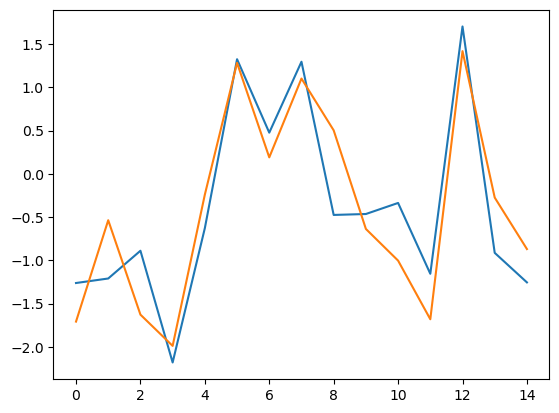

In [6]:
plt.plot(omega_s)
plt.plot(omega_t)


(array([280., 128.,  42.,  19.,  19.,   3.,   4.,   2.,   2.,   1.]),
 array([0.10480519, 0.95904042, 1.81327565, 2.66751088, 3.52174611,
        4.37598134, 5.23021657, 6.0844518 , 6.93868703, 7.79292226,
        8.64715749]),
 <BarContainer object of 10 artists>)

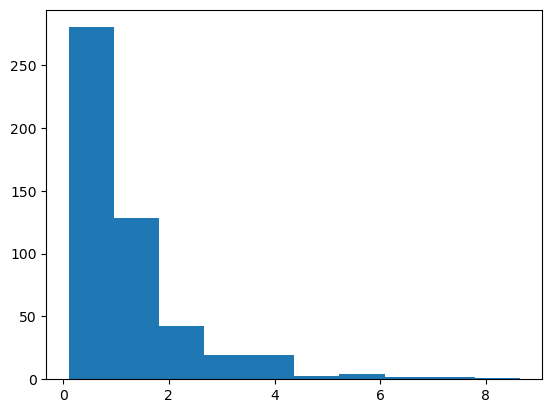

In [406]:
plt.hist(y_t)